# FacebookPagePage

In [1]:
import os
import torch
import numpy as np
import pickle
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# %pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

from torch_geometric.datasets import FacebookPagePage
from torch_geometric.transforms import NormalizeFeatures


import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from tqdm.notebook import tqdm

from torch_geometric.nn import GCNConv
import torch.nn.functional as F


2.1.1


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Stage 1 Train the base GNN model¶

In [3]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomNodeSplit(num_val=0.1, num_test=0.1),
])

# Load the dataset
dataset = FacebookPagePage(root='/tmp/FacebookPagePage', transform=transform)
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: FacebookPagePage():
Number of graphs: 1
Number of features: 128
Number of classes: 4
Data(x=[22470, 128], edge_index=[2, 342004], y=[22470], train_mask=[22470], val_mask=[22470], test_mask=[22470])
Number of nodes: 22470
Number of edges: 342004
Average node degree: 15.22
Number of training nodes: 17976
Training node label rate: 0.80
Has isolated nodes: False
Has self-loops: True
Is undirected: True


#### GCN model for Node Prediction

In [4]:
# train a GCN model for node classification
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(128, 64, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(64, 32, cached=True,
                             normalize=True)
        self.conv3 = GCNConv(32, 4, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x

In [5]:
GNNmodel = GCN()
GNNmodel, data = GNNmodel.to(device), data.to(device)
optimizer = torch.optim.Adam(GNNmodel.parameters(), weight_decay=1e-4)
n_epoch=1000
print(GNNmodel)

GCN(
  (conv1): GCNConv(128, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 4)
)


In [6]:
def train():
    GNNmodel.train()
    optimizer.zero_grad()
    out = GNNmodel(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    GNNmodel.eval()
    pred = GNNmodel(data.x, data.edge_index).argmax(dim=-1)
    mask_val = data.val_mask
    mask_test = data.test_mask
    accs_val = (int((pred[mask_val] == data.y[mask_val]).sum()) / int(mask_val.sum()))
    accs_test = (int((pred[mask_test] == data.y[mask_test]).sum()) / int(mask_test.sum()))
    return accs_val, accs_test

In [7]:
loss_record = []
val_acc_record = []
test_acc_record = []

for epoch in range(1, n_epoch):
    loss = train()
    val_acc, test_acc= test()
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
    loss_record.append(loss)
    val_acc_record.append(val_acc)
    test_acc_record.append(test_acc)

Epoch: 001, Loss: 1.3867, Val: 0.2964, Test: 0.2977
Epoch: 002, Loss: 1.3852, Val: 0.3222, Test: 0.3244
Epoch: 003, Loss: 1.3834, Val: 0.3685, Test: 0.3623
Epoch: 004, Loss: 1.3818, Val: 0.3907, Test: 0.3876
Epoch: 005, Loss: 1.3804, Val: 0.4077, Test: 0.4063
Epoch: 006, Loss: 1.3787, Val: 0.4174, Test: 0.4170
Epoch: 007, Loss: 1.3775, Val: 0.4237, Test: 0.4192
Epoch: 008, Loss: 1.3760, Val: 0.4237, Test: 0.4215
Epoch: 009, Loss: 1.3742, Val: 0.4268, Test: 0.4219
Epoch: 010, Loss: 1.3727, Val: 0.4335, Test: 0.4263
Epoch: 011, Loss: 1.3709, Val: 0.4384, Test: 0.4317
Epoch: 012, Loss: 1.3690, Val: 0.4406, Test: 0.4317
Epoch: 013, Loss: 1.3672, Val: 0.4388, Test: 0.4295
Epoch: 014, Loss: 1.3659, Val: 0.4366, Test: 0.4268
Epoch: 015, Loss: 1.3639, Val: 0.4326, Test: 0.4228
Epoch: 016, Loss: 1.3622, Val: 0.4237, Test: 0.4161
Epoch: 017, Loss: 1.3605, Val: 0.4068, Test: 0.4059
Epoch: 018, Loss: 1.3585, Val: 0.3885, Test: 0.3903
Epoch: 019, Loss: 1.3570, Val: 0.3689, Test: 0.3787
Epoch: 020, 

In [ ]:
# 儲存模型
torch.save(GNNmodel, './models/1_GCN_model.pt')

# 匯入模型
# GNNmodel = torch.load('./models/1_GCN_model.pt')

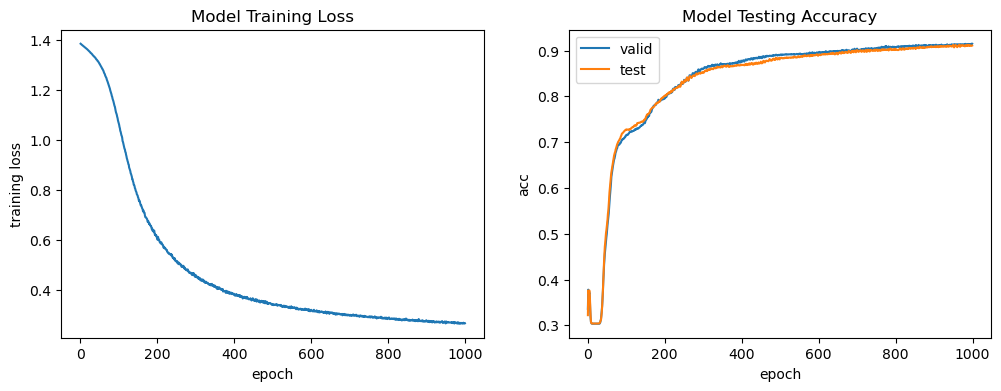

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, n_epoch), loss_record)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title(f"Model Training Loss")


plt.subplot(1,2,2)
plt.plot(range(1, n_epoch), val_acc_record, label='valid')
plt.plot(range(1, n_epoch), test_acc_record, label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.title(f"Model Testing Accuracy")
plt.savefig('./plot/1_GCNresult.png', dpi=300)

plt.show()

## Stage 2: Use GNNExplainer to obtain subgraph explanations

#### Generate subgraph by GNNExplainer 

We also support many different types of masks, these are set with `node_mask_type` and `edge_mask_type`, and can be:

None will not mask any nodes/edges  
`"object"` will mask each node/edge  
`"common_attributes"` will mask each node feature/edge attribute  
`"attributes"` will mask each node feature/edge attribute separately across all nodes/edges  

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

# set up explainer
# hops = 3
explainer = Explainer(
    model=GNNmodel,
    algorithm=GNNExplainer(epochs=200, num_hops=3),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

In [ ]:
# 匯入 module.py
from importlib import reload
import module
reload(module) 

<module 'module' from '/Users/liang/Documents/NCKU_DS/圖機器學習專討/final/module.py'>

#### Build a dataset with train, valid, test
p.s. 後續只使用 train:100, valid:20, test:20

In [ ]:
num = 400
dataset_train = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=3, train=True)
    dd = d.get_data()
    dataset_train.append(dd)

# with open('./dataset/dataset_train.pickle', 'wb') as file:
#     pickle.dump(dataset_train, file)
# print("已將 dataset_train 存至 ./dataset/dataset_train.pickle")

  0%|          | 0/400 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
3個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中..

In [ ]:
num = 50
dataset_valid5 = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=5, train=False)
    dd = d.get_data()
    dataset_valid5.append(dd)

# with open('./dataset/dataset_valid5.pickle', 'wb') as file:
#     pickle.dump(dataset_valid5, file)
# print("已將 dataset_valid5 存至 ./dataset/dataset_valid5.pickle")

  0%|          | 0/50 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中..

In [ ]:
num = 50
dataset_test5 = []
for i in tqdm(range(num)):
    d = module.SubgraphData(data, explainer, k=5, train=False)
    dd = d.get_data()
    dataset_test5.append(dd)

# with open('./dataset/dataset_test5.pickle', 'wb') as file:
#     pickle.dump(dataset_test5, file)
# print("已將 dataset_test5 存至 ./dataset/dataset_test5.pickle")


  0%|          | 0/50 [00:00<?, ?it/s]

GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中...
子圖生成完畢
5個子圖的所有節點，在原圖中存在路徑!
GNNExplainer 生成子圖中..